# CHIPPR

This notebook demonstrates the use of the Cosmological Hierarchical Inference with Probabilistic Photometric Redshifts (CHIPPR) package to estimate population distributions based on a catalog of probability distributions.

The package supports two primary objectives: simulation of catalogs and inference of posterior distributions over parameters defining population distributions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
import cProfile, pstats, StringIO
import os

import chippr
from chippr import *

/Users/aimalz/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
help(chippr)

Help on package chippr:

NAME
    chippr

FILE
    /Users/aimalz/anaconda/lib/python2.7/site-packages/chippr-0.1-py2.7.egg/chippr/__init__.py

PACKAGE CONTENTS
    catalog
    catalog_plots
    defaults
    discrete
    gauss
    gmix
    log_z_dens
    log_z_dens_plots
    mvn
    plot_utils
    sim_utils
    stats
    utils

SUBMODULES
    d
    plots
    pu
    s
    su
    u

DATA
    __loader__ = <zipimporter object "/Users/aimalz/anaconda/lib/python2.7...
    a_bfe = 1.0
    a_exp = 1.0
    a_int = 0.5
    a_map = 1.0
    a_mle = 1.0
    a_stk = 1.0
    a_tru = 1.0
    c_bfe = 'k'
    c_exp = 'k'
    c_int = 'k'
    c_map = 'k'
    c_mle = 'k'
    c_stk = 'k'
    c_tru = 'k'
    constant_sigma = 0.05
    d_bfe = [(0, (1, 1))]
    d_exp = [(0, (2.5, 2.5))]
    d_int = [(0, (1, 1))]
    d_map = [(0, (7.5, 7.5))]
    d_mle = [(0, (2.5, 2.5))]
    d_stk = [(0, (7.5, 7.5))]
    d_tru = [(0, (1, 1))]
    eps = 2.220446049250313e-16
    gr_threshold = 1.1
    l_bfe = 'Mean of\n Samples 

## Simulation

Many of `chippr`'s modules are used to produce mock catalogs of individual posterior probability distributions.

To create a catalog, we must first define a true redshift distribution function.  It may be a Gaussian distribution of the `gauss` class, a Gaussian mixture distribution of the `gmix` class, or a binned discrete distribution of the `discrete` class.  In this case, we will consider a mixture of three Gaussian distributions to represent the true redshift distribution.

In [3]:
true_amps = np.array([0.20, 0.35, 0.55])
true_means = np.array([0.5, 0.2, 0.75])
true_sigmas = np.array([0.4, 0.2, 0.1])

true_nz = gmix(true_amps, true_means, true_sigmas, limits=(0., 1.))

Next, we sample true redshifts from that distribution.

In [4]:
N =10**4 #2**16

true_zs = true_nz.sample(N)

`chippr` supports the use of a parameter file to specify various options for the catalog simulator to turn on and off.

In [5]:
param_loc = 'params.txt'
params = sim_utils.ingest(param_loc)
print(params)

{'constant_sigma': ['0.05'], 'outlier_fraction': ['0.2'], 'variable_sigmas': ['0'], 'catastrophic_outliers': ['0'], 'outlier_mean': ['0.4'], 'outlier_sigma': ['0.075']}


To make a catalog, we must specify an interim prior redshift distribution $n^{*}(z)$, regardless of what quantity we wish to infer using the catalog.  So far, only discrete distributions are supported, but this will soon be changed.  The simplest discrete distribution is uniform.

In [6]:
bin_ends = np.array([0., 1.])
weights = np.array([1.])

int_prior = discrete(bin_ends, weights)

Now we are ready to make a catalog.  To do this we instantiate a `catalog` object and then create a catalog of indiviual posterior distributions based on the true redshifts and the interim prior.  By default, the catalog generator will make some informative plots along the way.  The included plots are a histogram of the true redshifts and a scatterplot of the true redshifts and the centers of the individual Gaussian posteriors.  Support for other posterior forms will be added soon.  Additionally, the catalog is expressed as normalized binned histogram heights.  Support for other parametrizations of the individual posteriors may be added in the future.

{'constant_sigma': 0.05, 'outlier_fraction': 0.2, 'variable_sigmas': 0, 'catastrophic_outliers': ['0'], 'n_bins': 10, 'outlier_mean': 0.4, 'outlier_sigma': 0.075, 'bin_max': 1.0, 'bin_min': 0.0}
         999227 function calls (995077 primitive calls) in 4.479 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       21    1.612    0.077    1.612    0.077 {built-in method poll}
   112015    0.502    0.000    0.502    0.000 {method 'reduce' of 'numpy.ufunc' objects}
    10001    0.389    0.000    1.372    0.000 build/bdist.macosx-10.6-x86_64/egg/chippr/catalog.py:80(coarsify)
   110011    0.309    0.000    0.938    0.000 /Users/aimalz/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:1743(sum)
        1    0.098    0.098    4.476    4.476 build/bdist.macosx-10.6-x86_64/egg/chippr/catalog.py:100(create)
        1    0.083    0.083    0.102    0.102 {matplotlib._path.get_path_collection_extents}
    15669    0.080    

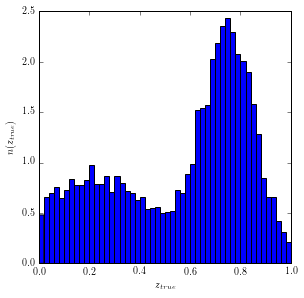

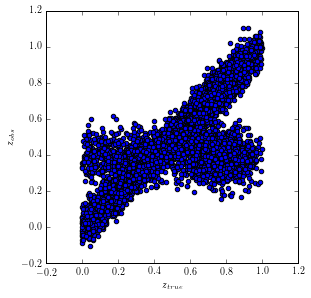

In [7]:
pr = cProfile.Profile()
pr.enable()

results_loc = os.path.join(os.path.join(os.path.join(os.path.join('..', '..'), 'research'), 'results'), 'demo')

posteriors = catalog(params=param_loc, loc=results_loc)
output = posteriors.create(true_zs, int_prior)

data = np.exp(output['log_interim_posteriors'])

pr.disable()
s = StringIO.StringIO()
sortby = 'tottime'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print s.getvalue()

We can also plot a histogram of the centers of the individual Gaussian posteriors, a binned version of the true redshift distribution, and the $n(z)$ resulting from stacking the individual posteriors.

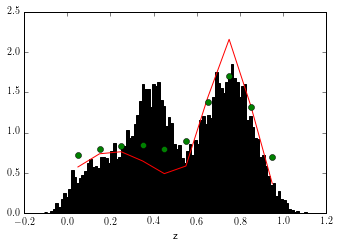

In [8]:
plt.hist(posteriors.obs_samps, bins=100, normed=True, color="k")
plt.plot(posteriors.x_coarse, true_nz.evaluate(posteriors.x_coarse), "r-")
plt.plot(posteriors.x_coarse, np.sum(data, axis=0) / N, "go")
plt.xlabel("z")

It is also informative to see what a few individual likelihoods and binned posteriors look like.

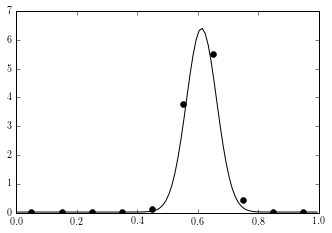

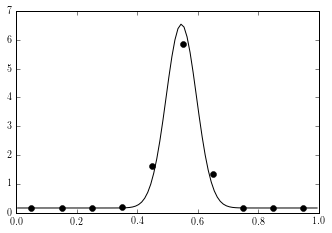

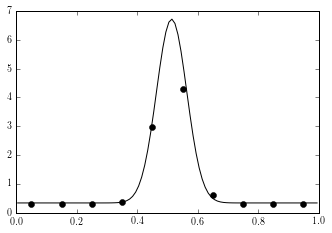

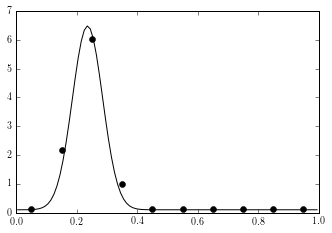

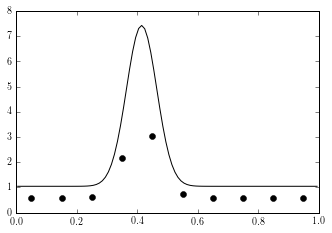

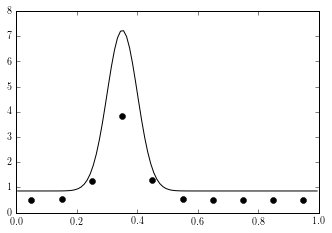

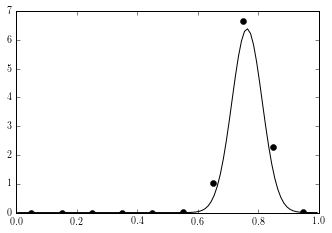

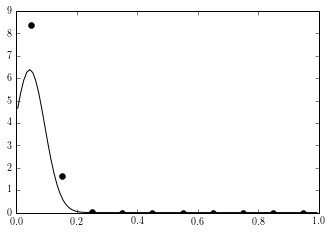

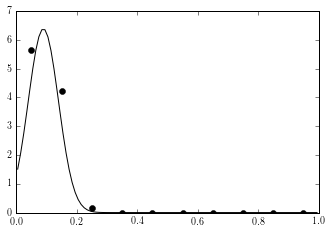

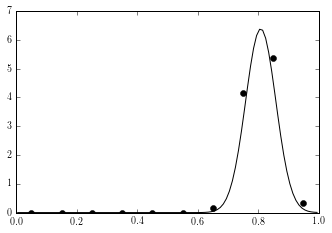

In [9]:
for n, z in enumerate(data[:10]):
    plt.plot(posteriors.x_coarse, data[n], 'ko')
    plt.plot(posteriors.x_fine, posteriors.obs_lfs[n], 'k-')
    plt.show()

We finish by saving the data as a plaintext file.  Support for more file formats will be added soon.

In [10]:
saved_location = 'data'
saved_type = '.txt'
posteriors.write(loc=saved_location, style=saved_type)

## Inference

`chippr` currently contains one inference module to probe the posterior distribution of parameters defining the redshift distribution function.

To perform inference, we must create a catalog object.  This may be done by making a new catalog as is done above or by reading in an existing catalog file.

In [11]:
param_loc = 'params.txt'
results_loc = os.path.join(os.path.join(os.path.join(os.path.join('..', '..'), 'research'), 'results'), 'demo')
simulated_posteriors = catalog(params=param_loc, loc=results_loc)

saved_location = 'data'
saved_type = '.txt'
data = simulated_posteriors.read(loc=saved_location, style=saved_type)

{'constant_sigma': 0.05, 'outlier_fraction': 0.2, 'variable_sigmas': 0, 'catastrophic_outliers': ['0'], 'n_bins': 10, 'outlier_mean': 0.4, 'outlier_sigma': 0.075, 'bin_max': 1.0, 'bin_min': 0.0}


The catalog file contains three components: the `bin_ends`, the `log_interim_prior`, and the `log_interim_posteriors`.  The bin endpoints can be processed to enable their use in constructing a prior distribution over the parameters determining the redshift distribution function.

In [12]:
zs = data['bin_ends']
nz_intp = np.exp(data['log_interim_prior'])
z_posts = np.exp(data['log_interim_posteriors'])

z_difs = zs[1:]-zs[:-1]
z_mids = (zs[1:]+zs[:-1])/2.
n_bins = len(z_mids)

The prior distribution must be a `mvn` object, defined by a mean vector and covariance matrix over the parameters defining the redshift distribution.  In this case, it is intuitive to use the definition of the binning strategy to create the prior distribution since the parameters are normalized histogram bin heights, the same parametrization used for the catalog entries themselves.

In [13]:
# prior_sigma = 0.16
# prior_var = np.eye(n_bins)
# for b in range(n_bins):
#     prior_var[b] = 1. * np.exp(-0.5 * (z_mids[b] - z_mids) ** 2 / prior_sigma ** 2)
# l = 1.e-4
# prior_var = prior_var+l*np.identity(n_bins)

prior_var = np.eye(n_bins)
for k in range(n_bins):
    prior_var[k] = 1. * np.exp(-0.5 * (z_mids[k] - z_mids) ** 2 / 0.05 ** 2)

prior_mean = nz_intp
prior = mvn(prior_mean, prior_var)

We create a `log_z_dens` object from the dictionary of catalog parameters and the prior distribution.  We include the optional specification of the true distribution, since it is available in this case.

In [14]:
nz = log_z_dens(data, prior, truth=true_nz, vb=True)

10 bins, 10000 interim posterior PDFs


We perform calculations of a few of the simplest estimators of the redshift distribution function $\hat{n}(z)$.  The stacked estimator is defined as $\hat{n}(z)=\frac{1}{N}\sum p(z|\vec{d},n^{*}(z))$.  The marginalized maximum a posteriori estimator is defined as $\hat{n}(z)=\hat{n}(\{argmax[p(z|\vec{d},n^{*}(z))]\})$.  The marginalized expected value estimator is defined as $\hat{n}(z)=\hat{n}(\{E[p(z|\vec{d},n^{*}(z))]\})$.

In [15]:
nz_stacked = nz.calculate_stacked()
nz_mmap = nz.calculate_mmap()
nz_mexp = nz.calculate_mexp()

The `log_z_dens` object enables easy comparison between estimators using the Kullback-Leibler Divergences (when the true distribution is available) and root-mean-square differences.

In [18]:
nz_stats = nz.compare()

{'kld': {'log_mmap_nz': 21.842707893409688, 'log_stacked_nz': 17.37704281860826, 'log_mexp_nz': 19.482337709289606}, 'rms': {'mmap_nz__stacked_nz': 0.26382284012886248, 'stacked_nz__mmap_nz': 0.26382284012886248, 'mexp_nz__mexp_nz': 0.0, 'mexp_nz__stacked_nz': 0.55043048500284508, 'stacked_nz__stacked_nz': 0.0, 'mmap_nz__mmap_nz': 0.0, 'mexp_nz__mmap_nz': 0.4436994478247635, 'stacked_nz__mexp_nz': 0.55043048500284508, 'mmap_nz__mexp_nz': 0.4436994478247635}, 'log_rms': {'log_mmap_nz__log_mmap_nz': 0.0, 'log_mexp_nz__log_stacked_nz': 0.45613907189756897, 'log_mexp_nz__log_mmap_nz': 0.36122020761789231, 'log_stacked_nz__log_stacked_nz': 0.0, 'log_stacked_nz__log_mexp_nz': 0.45613907189756897, 'log_mmap_nz__log_stacked_nz': 0.28788199621807053, 'log_mexp_nz__log_mexp_nz': 0.0, 'log_stacked_nz__log_mmap_nz': 0.28788199621807053, 'log_mmap_nz__log_mexp_nz': 0.36122020761789231}}


We may next calculate the marginalized maximum likelihood estimator (which actually returns the parameters maximizing the posterior probability).

In [19]:
pr = cProfile.Profile()
pr.enable()

nz_mmle = nz.calculate_mmle(nz_stacked)

pr.disable()
s = StringIO.StringIO()
sortby = 'tottime'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print s.getvalue()

('starting at', array([-0.32455311, -0.22710677, -0.17642196, -0.17177796, -0.21918778,
       -0.11034003,  0.31868006,  0.53324216,  0.27490132, -0.34952667]), -1325.9271402797638)
 final_simplex: (array([[-0.13040452,  0.1266737 ,  0.12758214, -0.01721328, -0.30622886,
        -0.26024135,  0.75971713,  1.19770368,  0.72286253, -0.80220572],
       [-0.13036799,  0.12667821,  0.12757581, -0.0172026 , -0.30626228,
        -0.26027142,  0.75972404,  1.19768978,  0.7228814 , -0.8021696 ],
       [-0.13039465,  0.12666029,  0.12757898, -0.01718244, -0.30631033,
        -0.26026639,  0.75969782,  1.19768824,  0.7228467 , -0.80219504],
       [-0.13036288,  0.12670152,  0.12757349, -0.0172196 , -0.30618534,
        -0.26028882,  0.759763  ,  1.19770578,  0.72287841, -0.80217352],
       [-0.13035265,  0.12668663,  0.12760816, -0.01722926, -0.30614735,
        -0.26030602,  0.75974435,  1.19771282,  0.72288479, -0.80216913],
       [-0.13038767,  0.12670783,  0.12754266, -0.01723998, -0.30

If we are very ambitious, we can run an MCMC sampler (currently use of `emcee` is supported, but other samplers may be added in the future) to probe the posterior distribution of the parameter values.  To do this, we initialize the sampler with samples from the prior distribution.

In [20]:
n_ivals = 2*n_bins
initial_values = prior.sample(n_ivals)

pr = cProfile.Profile()
pr.enable()

nz_samps = nz.calculate_samples(initial_values)

pr.disable()
s = StringIO.StringIO()
sortby = 'tottime'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print s.getvalue()

beginning sampling 1
         221694293 function calls in 199.459 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    22040  103.188    0.005  171.614    0.008 build/bdist.macosx-10.6-x86_64/egg/chippr/utils.py:10(safe_log)
220400010   44.587    0.000   44.587    0.000 {max}
   159626   23.826    0.000   23.826    0.000 {numpy.core.multiarray.array}
    22040   15.488    0.001  194.970    0.009 build/bdist.macosx-10.6-x86_64/egg/chippr/log_z_dens.py:95(evaluate_log_hyper_likelihood)
    97031    7.006    0.000    7.006    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   110000    1.647    0.000    2.077    0.000 build/bdist.macosx-10.6-x86_64/egg/chippr/stats.py:148(cft)
    66130    0.577    0.000    7.565    0.000 /Users/aimalz/anaconda/lib/python2.7/site-packages/numpy/core/fromnumeric.py:1743(sum)
   121020    0.493    0.000    0.493    0.000 {sum}
    11000    0.356    0.000    2.970    0.000 build/bdist.macosx-10.6

The `log_z_dens` object stores the estimators that have been calculated as well as all metadata associated with the posterior samples.  The storage of the metadata and samples will soon be eliminated in favor of saved files, as that information may necessitate a great deal of memory.

In [21]:
nz.info['estimators'].keys()

['log_sampled_nz_meta_data',
 'log_mmle_nz',
 'log_sampled_nz',
 'log_mexp_nz',
 'log_mmap_nz',
 'log_stacked_nz',
 'log_mean_sampled_nz']

Currently, the results of all previously calculated estimators (and the true redshift density function, if it was provided) may be plotted automatically.

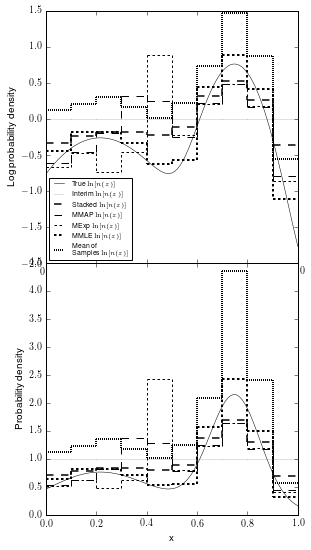

In [25]:
nz.plot_estimators('final_plot.png')

The `log_z_dens` object supports writing the information associated with the estimators to a file in the `pickle` format, though other formats may be added in the future.

In [23]:
nz.write('nz.p')

The following quantities were written to nz.p in the pickle format:
bin_ends
log_tru_nz
truth
estimators
stats
log_interim_posteriors
log_interim_prior


Here we demonstrate that the written estimators may be loaded from files as well for future use.

In [24]:
nz.info = nz.read('nz.p')
print(nz)

The following quantities were read from nz.p in the pickle format:
stats
log_tru_nz
truth
estimators
bin_ends
log_interim_posteriors
log_interim_prior
